# Visualization

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import defaultdict

## RQ1. Distribution of Distribution of Incorrect Coreference

In [10]:
issue_types = ['EE', 'ME', 'MM', 'EM', 'CE', 'SE']
genMethodNameList = ['SIT', 'PatInv', 'CAT', 'Checklist', 'Textattack', 'Crest']
source_cnt = defaultdict(lambda: defaultdict(int))

oriBug_list, newBug_list, bothBug_list, correct_list = [], [], [], []

# Note that we combine
for genMethod in genMethodNameList:
    file = '../Output/RQ1-IssueRevealing/label/FurtherAnalysisOnDistribution/{}.txt'.format(genMethod)

    oriBug, newBug, bothBug, correct = 0, 0, 0, 0
    content = open(file).readlines()

    cnt = 0
    oriResult, newResult = None, None
    for line in content:
        if oriResult is not None and newResult is not None:
            if oriResult == True and newResult == True:
                bothBug += 1
            elif oriResult == True and newResult == False:
                oriBug += 1
            elif oriResult == False and newResult == True:
                newBug += 1
            else:
                correct += 1
            oriResult, newResult = None, None

        if line.startswith('oriBuggy:'):
            result = line.strip().split(': ')[1]
            oriResult = True if result != 'N' else False
        if line.startswith('newBuggy:'):
            result = line.strip().split(': ')[1]
            newResult = True if result != 'N' else False

    oriBug_list.append(oriBug)
    newBug_list.append(newBug)
    bothBug_list.append(bothBug)
    correct_list.append(correct)

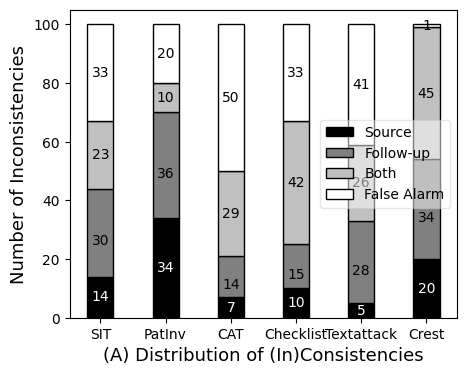

In [12]:
N = len(genMethodNameList)

level_1 = oriBug_list
level_2 = [x + y for x, y in zip(level_1, newBug_list)]
level_3 = [x + y for x, y in zip(level_2, bothBug_list)]

ind = np.arange(N)  # the x locations for the groups
width = 0.4  # the width of the bars: can also be len(x) sequence

plt.rcdefaults()
fig = plt.figure(figsize=(5, 4))

ax = fig.add_subplot(1, 1, 1)
labels = ['Source', 'Follow-up', 'Both', 'False Alarm']

p1 = ax.bar(ind, oriBug_list, width, tick_label=genMethodNameList, label=labels[0], color='black', ec='black')
p2 = ax.bar(ind, newBug_list, width,
            bottom=level_1, label=labels[1], color='gray', ec='black')  # lavender
p3 = ax.bar(ind, bothBug_list, width,
            bottom=level_2, label=labels[2], color='silver', ec='black')  # lavender
p4 = ax.bar(ind, correct_list, width,
            bottom=level_3, label=labels[3], color='white', ec='black')  # lavender

ax.axhline(0, color='gray', linewidth=0.8)

ax.set_xlabel('(A) Distribution of (In)Consistencies', fontsize=13)
ax.set_ylabel('Number of Inconsistencies', fontsize=13)
ax.legend(loc='right', framealpha=0.5)

# Label with label_type 'center' instead of the default 'edge'
ax.bar_label(p1, label_type='center',color='white')
ax.bar_label(p2, label_type='center', padding=-6)
ax.bar_label(p3, label_type='center')
ax.bar_label(p4, label_type='center')

plt.xticks()

# plt.show()
plt.savefig('../Figure/rq1-distribution.png')

### RQ2. Test Quality

The number of follow-up inputs that preserve/change the coreference of the source input


In [13]:
# Read files and count

genMethodNameList = ['SIT', 'PatInv', 'CAT', 'Checklist', 'Textattack', 'Crest']

changed = []

for genMethod in genMethodNameList:
    file = '../Output/RQ2-Quality/label/label100_{}.txt'.format(genMethod)
    lines = open(file).readlines()
    cur_change_cnt = 0

    for lid, line in enumerate(lines, 1):
        if line.startswith('CorefChanged:'):
            result = line.strip().split(': ')[1]
            if result == 'True':
                cur_change_cnt += 1
            elif result == 'False':
                continue
            else:
                print('Method: {}, line: {}. Expected: True/False. Got: {}'.format(genMethod, lid, result))
                raise ValueError('Incorrect labeling is found!')
    changed.append(cur_change_cnt)

# To check:
assert len(changed) == len(genMethodNameList)
for name, num in zip(genMethodNameList, changed):
    print("{}: {}".format(name, num))

SIT: 52
PatInv: 25
CAT: 43
Checklist: 33
Textattack: 77
Crest: 2


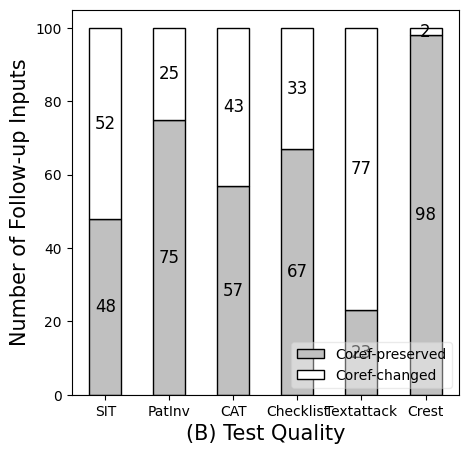

In [14]:
# Draw

N = len(genMethodNameList)

preserved = [100 - x for x in changed]
ind = np.arange(N)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence

plt.rcdefaults()
fig = plt.figure(figsize=(5, 5))

ax = fig.add_subplot(1, 1, 1)
labels = ['Coref-preserved', 'Coref-changed']

p1 = ax.bar(ind, preserved, width, tick_label=genMethodNameList, label=labels[0], color='silver', ec='black')
p2 = ax.bar(ind, changed, width,
            bottom=preserved, label=labels[1], color='white', ec='black')  # lavender

ax.axhline(0, color='gray', linewidth=0.8)

ax.set_ylabel('Number of Follow-up Inputs', fontsize=15)
ax.set_xlabel('(B) Test Quality', fontsize=15)
ax.legend(loc='lower right', framealpha=0.4)


# Label with label_type 'center' instead of the default 'edge'
ax.bar_label(p1, label_type='center',fontsize=12)
ax.bar_label(p2, label_type='center',fontsize=12)

plt.savefig('../Figure/rq2-quality.png')

## RQ2. Test Quality - Semantic Similarity

In [5]:
# Read and count

genMethodNameList = ['SIT', 'PatInv', 'CAT', 'Checklist', 'Textattack', 'Crest']
metrics = ['semSim', 'natDiff']

genMethod = genMethodNameList[0]

# Visualize all
df_all = None
for genMethod in genMethodNameList:
    df = pd.read_csv('../Output/RQ2-Quality/similarity/Eval_Sem_Nat_{}.tsv'.format(genMethod), delimiter='\t')
    if df_all is None:
        df_all = df
    else:
        df_all = pd.concat([df_all, df], axis=0)


df = df_all
data = []
for metric in metrics:
    y1 = df[df['CorefChanged']][metric].values
    y2 = df[df['CorefChanged'] == False][metric].values
    data.append((y1, y2))

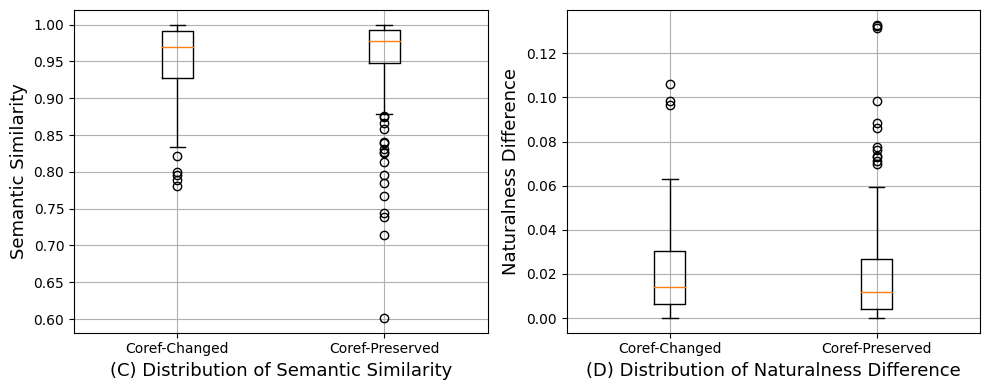

In [26]:
# Draw


fig = plt.figure(figsize=(10, 4))
plt.rcdefaults()

title = ['Semantic Similarity', 'Naturalness Difference']
xtitle = ['(C) Distribution of Semantic Similarity', '(D) Distribution of Naturalness Difference']

for ti, title in enumerate(title, 1):
    ax1 = fig.add_subplot(1, 2, ti)

    ax1.boxplot(data[ti-1])

    ax1.grid()
    ax1.set_xscale('linear') # 'log'
    ax1.set_xlabel(xtitle[ti-1], fontsize = 13)
    ax1.set_ylabel(title, fontsize = 13
                   )
    plt.setp(ax1, xticks=[1.0, 2.0], xticklabels=['Coref-Changed', 'Coref-Preserved'])


plt.tight_layout()
plt.savefig('../Figure/rq2-similarity.png'.format(genMethod))

## RQ3. Distribution of Issue Types

In [15]:
issue_types = ['EE', 'ME', 'MM', 'EM', 'CE', 'SE']

type_cnt = defaultdict(lambda: defaultdict(int))

for genMethod in genMethodNameList:
    file = '../Output/RQ3-IssueType/label/{}.txt'.format(genMethod)
    content = open(file).readlines()
    for line in content:
        if line.startswith('oriBuggy: ') or line.startswith('newBuggy: '):
            result = line.strip().split(': ')[1]
            if result != 'N':
                type_set = result.split(', ')
                for t in type_set:
                    type_cnt[genMethod][t] += 1

# For debug
for genMethod in genMethodNameList:
    print(genMethod)
    for key, val in type_cnt[genMethod].items():
        print("{}: {}".format(key, val))
    print()

SIT
SE: 7
MM: 42
EM: 40
EE: 12
ME: 25

PatInv
MM: 42
EM: 33
ME: 29
EE: 7
SE: 10

CAT
EE: 11
EM: 47
MM: 44
SE: 14
ME: 26
CE: 2

Checklist
EE: 39
MM: 25
SE: 24
ME: 48
EM: 14
CE: 4

Textattack
MM: 17
ME: 49
EM: 15
SE: 15
EE: 23

Crest
SE: 36
ME: 27
EE: 47
CE: 26
EM: 33
MM: 46



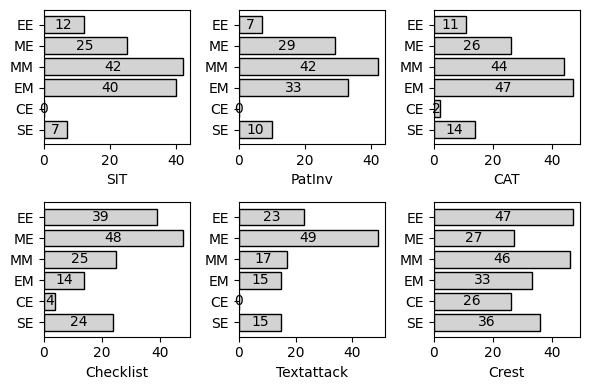

In [21]:
# Draw

plt.rcdefaults()
fig = plt.figure(figsize=(6, 4))

for i, genMethod in enumerate(genMethodNameList, 1):
    ax = fig.add_subplot(2, 3, i)

    y_pos = np.arange(len(type_cnt[genMethod]))
    x_values = []
    x_labels = []

    for t in issue_types:
        x_labels.append(t)
        x_values.append(type_cnt[genMethod][t])

    p1 = ax.barh(y_pos, x_values, height=0.8, align='center', color='lightgray', ec='black')
    ax.set_yticks(y_pos, labels=x_labels)
    ax.bar_label(p1, label_type='center')

    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel(genMethod)
plt.tight_layout()

# plt.show()
plt.savefig('../Figure/rq3-issue_type.png')